In [1]:
from common import get_books_df

df = get_books_df(download=False,include_users=True)

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9
Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9
Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9
Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9



INFO:common:Successfully read CSVs into a dataframe


# Ideas for a book recommendation engine

When recommending a new book to a user based on his previous likings,
the key idea is that the recommended books should be <b> similar </b> to the ones he 
already read and liked. Let's explore how this similarity could be measured. Note that this is a very simple demonstration of
what could the recommendation engine do, therefore the packages used here are not in the requirements file. If you want to play with the notebook and install missing packages, you can type `!pip3 install <package-name>` into a cell and run it.

## 1) Other readers with similar taste

First, we can find users with that liked the same books as our analyzed user and see 
what other books they liked.

In [31]:
df["Book-Title"] = df["Book-Title"].str.lower()

In [32]:
user = df[(df["Book-Rating"]>=9)&(df["Book-Title"]=="the fellowship of the ring (the lord of the rings, part 1)")].sample(1)

In [33]:
user

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
261843,0345339703,the fellowship of the ring (the lord of the ri...,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...,115536,10,"ashland, ohio, usa",32.0


In [34]:
similar_readers = df[(df["Book-Title"]==user["Book-Title"].values[0])&(df["Book-Rating"]>=9)]["User-ID"].unique()
similar_readers_books = df[df["User-ID"].isin(similar_readers)]

In [35]:
suggestions = similar_readers_books.groupby("Book-Title").agg({"Book-Rating":["mean","count"]})
suggestions.columns = ["avg_rating","num_ratings"]

suggestions.drop(user["Book-Title"].values[0],axis=0,inplace=True)

suggestions[suggestions["num_ratings"]>=5].nlargest(5,"avg_rating")

,avg_rating,num_ratings
Book-Title,,
"the return of the king (the lord of the rings, part 3)",9.783333,60
"the two towers (the lord of the rings, part 2)",9.692308,65
harry potter and the prisoner of azkaban (book 3),9.652174,23
"tuesdays with morrie: an old man, a young man, and life's greatest lesson",9.625000,8
anthem,9.600000,5


Or we could find users that are similar by their age or residency and
suggest new books accordingly

In [36]:
user["Location"],user["Age"]

(261843    ashland, ohio, usa
 Name: Location, dtype: object,
 261843    32.0
 Name: Age, dtype: float64)

In [37]:
try:

    similar_users = df[(df["Location"]==user["Location"].values[0])&(df["Age"].between(user["Age"].values[0]-5,user["Age"].values[0]+5))]

    suggestions = similar_users.groupby("Book-Title").agg({"Book-Rating":["mean","count"]})
    suggestions.columns = ["avg_rating","num_ratings"]

    suggestions.drop(user["Book-Title"].values[0],axis=0,inplace=True)

    s = suggestions[suggestions["num_ratings"]>=1].nlargest(5,"avg_rating")
    print(s.to_string())
except:
    print("Could not find similar users")

                                                                  avg_rating  num_ratings
Book-Title                                                                               
harry potter and the sorcerer's stone (harry potter (paperback))        10.0            1
surrender my love                                                        8.0            1
whirlwind (the x-files)                                                  8.0            1


## 2) Books with similar content

We could also collect various books descriptions and compare them.

In [50]:
import requests
from lxml import html

In [49]:
r = requests.get("https://en.wikipedia.org/wiki/The_Fellowship_of_the_Ring")

In [82]:
tree = html.fromstring(r.content)
" ".join([i for i in tree.xpath("//p//text()")[:22]])

'\n\n The Fellowship of the Ring  is the first of three volumes of the epic novel [2]   The Lord of the Rings  by the English author  J. R. R. Tolkien . It is followed by  The Two Towers  and  The Return of the King . The action takes place in the  fictional universe  of  Middle-earth . The book was first published on 29 July 1954 in the United Kingdom.\n The volume consists of a foreword, in which the author discusses his writing of  The Lord of the Rings , a prologue titled "Concerning  Hobbits , and other matters", and the main narrative in Book I and Book II.\n'

From the contents of the wikipedia page, we could then extract the plot/description and
compare it with other plots. This would have to be a more advanced method/model for text comparison, or the focus would have to be on some keywords and checking if they are contained
in both descriptions (such as "adventure", "love", "murder", "comedy" etc.)

## 3) Visually similar books

It is also possible to judge books by their cover and find visually same books.

In [24]:
from PIL import Image
import numpy as np

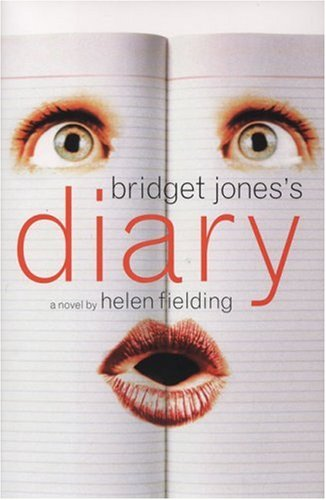

In [83]:
Image.open("./data/bj_diary.jpg")

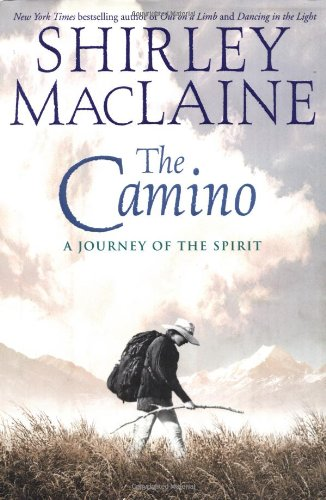

In [85]:
Image.open("./data/other_book.jpg")

In [25]:
user_book_image = np.asarray(Image.open("./data/bj_diary.jpg"))

other_book_image = np.asarray(Image.open("./data/other_book.jpg"))

In [26]:
assert(user_book_image.shape==other_book_image.shape)

In [27]:
(user_book_image==other_book_image).sum()/(500*326)

0.022208588957055214

With image comparison, we could suggest books with a similar cover (most likely with a more
complex comparison algorithm)

## 4) Numerically similar books

This approach would consist of obtaining numerical attributes of given titles
(their year of release, number of pages, rating etc.) and then finding similarities using
clustering algorithms. Additionally, text variables could be somehow encoded into numerical ones as well.

In [30]:
df.select_dtypes(include=["float","int"])

,User-ID,Book-Rating,Age
0,8,5,NaN
1,8,5,NaN
2,8,5,NaN
3,8,5,NaN
4,8,6,NaN
...,...,...,...
383837,246590,6,20.0
383838,259589,8,19.0
383839,259591,8,39.0
383840,259614,10,22.0


To conclude, there are many ways to find similar books and a good
recommendation system would probably try combine all of them.